# Aula 05 - Pipelines

Hoje olharemos para algumas ferramentas úteis para o desenvolvimento de modelos:

### - Primeira parte

- Motivação
- Pipelines

### - Segunda parte

- Exemplos
- Salvando o modelo

### - Terceira parte

- Exercícios

# Motivação

## Gestão de objetos

Durante o desenvolvimento de um novo modelo, lidamos com diversos objetos: tratadores de dados faltantes (imputers), normalizadores e preditores. A gestão desses objetos passa a ser caótica à medida que aumentamos a quantidade de pré-processamento de uma base. Para nos ajudar a fazer essa gestão, existem as **pipelines**.

## Pipelines

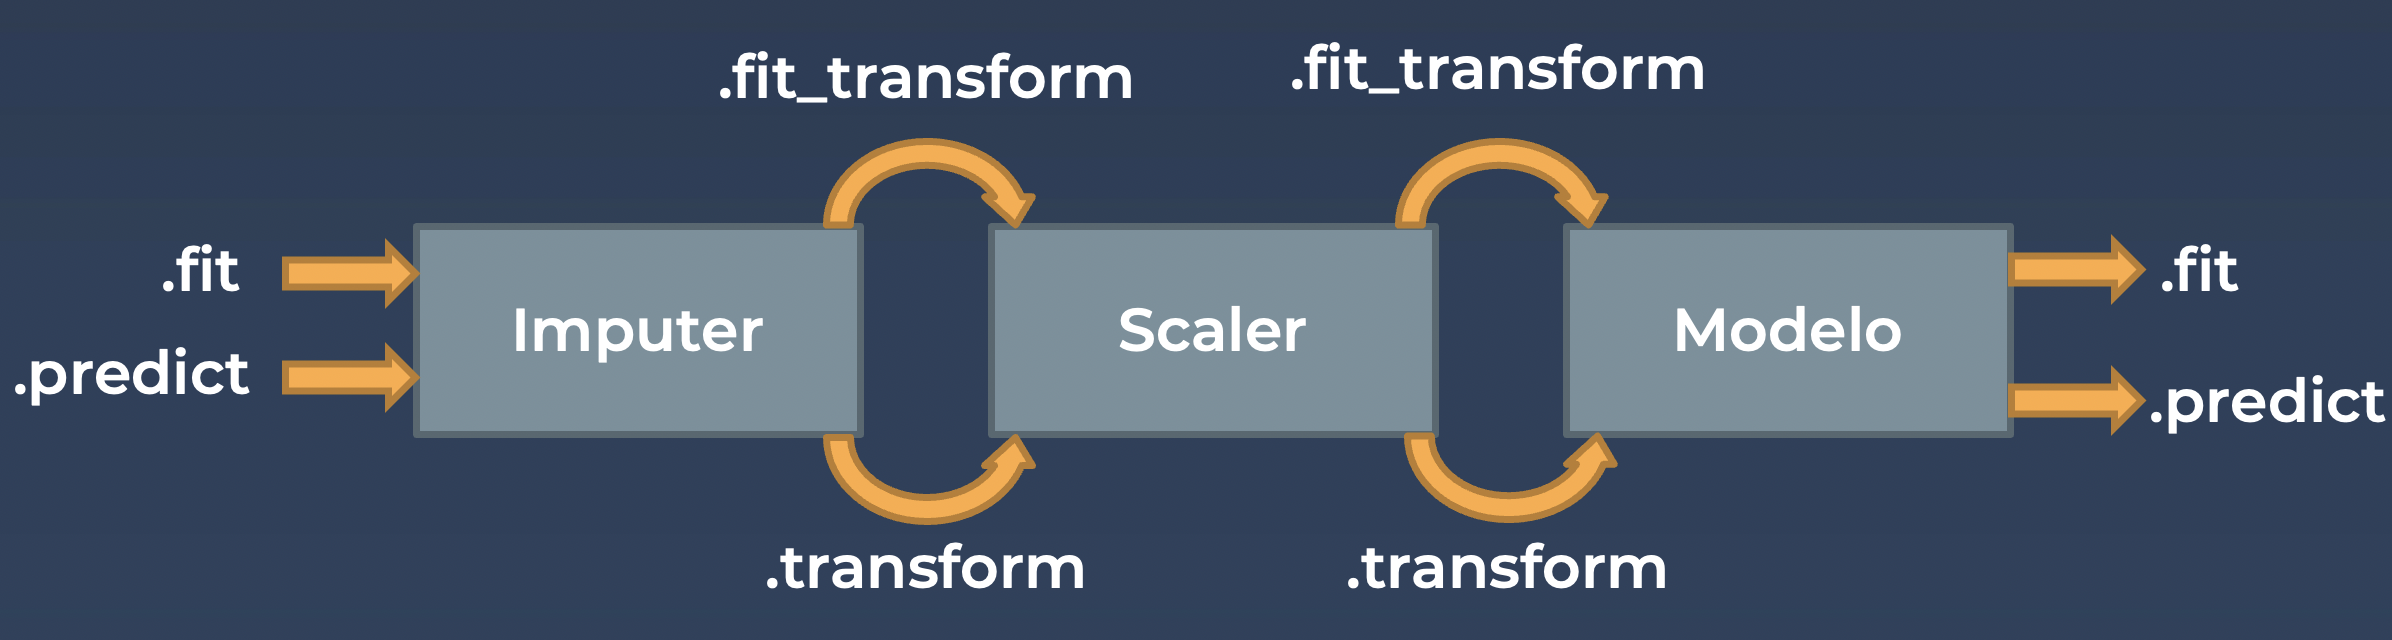

As pipelines concentram todos os objetos em uma única instância de maneira sequencial. Dessa maneira, podemos lidar com todo o conjunto de pré-processamento e modelo como um único objeto. Isso facilita, por exemplo, a exportação do binário do arquivo para ser utilizado por algum sistema em produção, o que veremos no módulo de **modelos produtivos**.

# Exemplos

### Dados fictícios

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.DataFrame(np.array([[5, 8, 10, np.nan, 7], 
                            [np.nan, 1, np.nan, 0, 9], 
                            [18, 10, 6, 7, 15], 
                            [5, 7, 9, np.nan, np.nan],
                            [1, 3, np.nan, np.nan, np.nan]]), columns=['a', 'b', 'c', 'd', 'e'])
df.head()

,a,b,c,d,e
0,5.0,8.0,10.0,NaN,7.0
1,NaN,1.0,NaN,0.0,9.0
2,18.0,10.0,6.0,7.0,15.0
3,5.0,7.0,9.0,NaN,NaN
4,1.0,3.0,NaN,NaN,NaN


In [3]:
from sklearn.impute import SimpleImputer

In [4]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [5]:
df.loc[:,:] = imputer.fit_transform(df)

df.head()

,a,b,c,d,e
0,5.00,8.0,10.000000,3.5,7.000000
1,7.25,1.0,8.333333,0.0,9.000000
2,18.00,10.0,6.000000,7.0,15.000000
3,5.00,7.0,9.000000,3.5,10.333333
4,1.00,3.0,8.333333,3.5,10.333333


### Um exemplo real

In [9]:
import pandas as pd

In [10]:
base_treino = pd.read_csv('adult_train.csv')

base_treino.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,17,Private,144752,10th,6,Never-married,Handlers-cleaners,Own-child,Amer-Indian-Eskimo,Male,0,0,20,United-States,<=50K
1,21,Local-gov,402230,Some-college,10,Never-married,Adm-clerical,Unmarried,White,Male,0,0,36,United-States,<=50K
2,41,Private,149576,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
3,29,Private,535978,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,<=50K
4,54,Private,111469,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K


In [7]:
base_treino.nunique()

age                   74
workclass              9
fnlwgt             24668
education             16
educational-num       16
marital-status         7
occupation            15
relationship           6
race                   5
gender                 2
capital-gain         119
capital-loss          97
hours-per-week        95
native-country        42
income                 2
dtype: int64

In [8]:
base_treino['income'] = base_treino['income'].map({'<=50K': 0, '>50K': 1})

In [11]:
categ_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
special_features = ['educational-num']

In [12]:
X = base_treino[categ_features + num_features + special_features]
y = base_treino['income']

print(X.shape, y.shape)

(39074, 12) (39074,)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                    y, 
                                                    test_size=0.1, 
                                                    random_state=12)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(35166, 12) (35166,)
(3908, 12) (3908,)


In [48]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from lightgbm import LGBMClassifier
pd.options.mode.chained_assignment = None

def transform_education(df):
    
    df = df.copy()
    
    df['educational-num'] = df['educational-num'].apply(lambda x: 1 if x >= 10 else 0)
    
    return df
    
    
categorizer = ColumnTransformer(transformers = [
    ('transf_categ', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categ_features),
    ('numeric', 'passthrough', num_features),   
    ('education', FunctionTransformer(transform_education), ['educational-num'])   
])


pipe = Pipeline(steps = [
    ('categ', categorizer),
    ('modelo', LGBMClassifier(is_unbalance=True, learning_rate=0.1, max_depth=7, n_estimators=150, importance_type='gain')),
])

## GridSearch com a Pipeline

In [42]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'modelo__max_depth': [5, 6, 7],
    'modelo__n_estimators': [20, 50, 70, 150],
    'modelo__learning_rate': [0.01, 0.1, 0.5, 1],
    'modelo__is_unbalance': [True, False]
}

clf = GridSearchCV(pipe, parameters, verbose=2, scoring='f1', cv=2)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 96 candidates, totalling 192 fits
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.01, modelo__max_depth=5, modelo__n_estimators=20; total time=   0.2s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.01, modelo__max_depth=5, modelo__n_estimators=20; total time=   0.1s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.01, modelo__max_depth=5, modelo__n_estimators=50; total time=   0.2s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.01, modelo__max_depth=5, modelo__n_estimators=50; total time=   0.2s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.01, modelo__max_depth=5, modelo__n_estimators=70; total time=   0.3s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.01, modelo__max_depth=5, modelo__n_estimators=70; total time=   0.3s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.01, modelo__max_depth=5, modelo__n_estimators=150; total time=   0.5s
[CV] END modelo__is_unbalance=True

[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.5, modelo__max_depth=7, modelo__n_estimators=20; total time=   0.2s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.5, modelo__max_depth=7, modelo__n_estimators=50; total time=   0.2s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.5, modelo__max_depth=7, modelo__n_estimators=50; total time=   0.2s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.5, modelo__max_depth=7, modelo__n_estimators=70; total time=   0.3s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.5, modelo__max_depth=7, modelo__n_estimators=70; total time=   0.3s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.5, modelo__max_depth=7, modelo__n_estimators=150; total time=   0.5s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=0.5, modelo__max_depth=7, modelo__n_estimators=150; total time=   0.5s
[CV] END modelo__is_unbalance=True, modelo__learning_rate=1, modelo__max_depth=5, modelo__n_estimators

[CV] END modelo__is_unbalance=False, modelo__learning_rate=0.1, modelo__max_depth=6, modelo__n_estimators=20; total time=   0.1s
[CV] END modelo__is_unbalance=False, modelo__learning_rate=0.1, modelo__max_depth=6, modelo__n_estimators=50; total time=   0.2s
[CV] END modelo__is_unbalance=False, modelo__learning_rate=0.1, modelo__max_depth=6, modelo__n_estimators=50; total time=   0.2s
[CV] END modelo__is_unbalance=False, modelo__learning_rate=0.1, modelo__max_depth=6, modelo__n_estimators=70; total time=   0.3s
[CV] END modelo__is_unbalance=False, modelo__learning_rate=0.1, modelo__max_depth=6, modelo__n_estimators=70; total time=   0.3s
[CV] END modelo__is_unbalance=False, modelo__learning_rate=0.1, modelo__max_depth=6, modelo__n_estimators=150; total time=   0.5s
[CV] END modelo__is_unbalance=False, modelo__learning_rate=0.1, modelo__max_depth=6, modelo__n_estimators=150; total time=   0.5s
[CV] END modelo__is_unbalance=False, modelo__learning_rate=0.1, modelo__max_depth=7, modelo__n_

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('categ',
                                        ColumnTransformer(transformers=[('transf_categ',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'gender',
                                                                          'native-country

In [47]:
print(clf.best_params_)

{'modelo__is_unbalance': True, 'modelo__learning_rate': 0.1, 'modelo__max_depth': 7, 'modelo__n_estimators': 150}


# Treino da Pipeline

In [49]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('categ',
                 ColumnTransformer(transformers=[('transf_categ',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country']),
                                                 ('numeric', 'passthrough',
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('education',
                  

In [50]:
y_train_pred = pipe.predict(X_train)

y_valid_pred = pipe.predict(X_valid)

print(y_train_pred.shape, y_valid_pred.shape)

(35166,) (3908,)


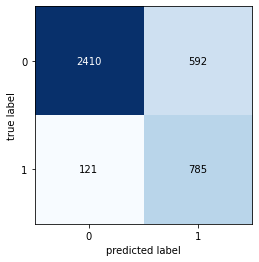

In [51]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm = confusion_matrix(y_valid, y_valid_pred)

plot_confusion_matrix(conf_mat=cm)
plt.show()

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc_train = accuracy_score(y_train, y_train_pred)
prec_train = precision_score(y_train, y_train_pred)
rec_train = recall_score(y_train, y_train_pred)

acc_valid = accuracy_score(y_valid, y_valid_pred)
prec_valid = precision_score(y_valid, y_valid_pred)
rec_valid = recall_score(y_valid, y_valid_pred)

print(f'Treino:\nAcc: {acc_train:.2f}, Precision: {prec_train:.2f}, Recall: {rec_train:.2f}')
print(f'Validação:\nAcc: {acc_valid:.2f}, Precision: {prec_valid:.2f}, Recall: {rec_valid:.2f}')

Treino:
Acc: 0.84, Precision: 0.62, Recall: 0.90
Validação:
Acc: 0.82, Precision: 0.57, Recall: 0.87


## Salvando o modelo

Serializando o nosso objeto

In [2]:
import pickle

In [65]:
# .pkl
# .joblib

#                          write bytes
with open('modelo_adult.pkl', 'wb') as file:
    pickle.dump(pipe, file)

## Carregando o modelo

In [4]:
def transform_education(df):
    
    df = df.copy()
    
    df['educational-num'] = df['educational-num'].apply(lambda x: 1 if x >= 10 else 0)
    
    return df

In [5]:
novo_objeto_modelo = pickle.load(open('modelo_adult.pkl', 'rb'))

In [6]:
novo_objeto_modelo

Pipeline(steps=[('categ',
                 ColumnTransformer(transformers=[('transf_categ',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country']),
                                                 ('numeric', 'passthrough',
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('education',
                  

In [14]:
novo_objeto_modelo.predict(X_valid)

array([1, 0, 0, ..., 0, 1, 0])

# Pra anotar

- Durante o seu desenvolvimento, sempre tenha em mente que, em algum momento, você utilizará uma Pipeline;
- Quase todas as bibliotecas de Machine Learning possuem Pipelines;
- O uso não é obrigatório, mas é recomendado.

-------